In [21]:
import pickle
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import arviz as az
import pandas as pd
from scipy.spatial.distance import pdist, squareform
from scipy.stats import spearmanr, pearsonr
from sklearn.decomposition import PCA
from networkx.algorithms import community

Load the dataset and do exploration

In [6]:
G = pickle.load(open('../data/ex_1_graph.pickle', 'rb'))

### Dataset Exploration
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")
print(f"Is directed: {G.is_directed()}")
print(f"Graph density: {nx.density(G):.2f}")

print("\n")

# List all unique node attribute keys
all_node_attrs = set()
for node in G.nodes():
    all_node_attrs.update(G.nodes[node].keys())
print(f"All available node attributes: {sorted(all_node_attrs)}")

# List all unique edge attribute keys
all_edge_attrs = set()
for u, v in G.edges():
    all_edge_attrs.update(G.edges[u, v].keys())
print(f"All available edge attributes: {sorted(all_edge_attrs)}")

print("\n")

# Example: first node and all its at tributes
first_node = list(G.nodes())[0]
print(f"Example node: {first_node}")
print(f"Node attributes: {G.nodes[first_node]}")

# Example: first edge and all its attributes
first_edge = list(G.edges())[0]
print(f"Example edge: {first_edge}")
print(f"Edge attributes: {G.edges[first_edge]}")

print("\n")

print(f"Graph attributes: {dict(G.graph)}")

degrees = [G.degree(n) for n in G.nodes()]
print(f"Degree - Min: {min(degrees)}, Max: {max(degrees)}, Mean: {np.mean(degrees):.2f}")
if nx.is_connected(G):
    print(f"Avg shortest path: {nx.average_shortest_path_length(G):.2f}")


Number of nodes: 60
Number of edges: 498
Is directed: False
Graph density: 0.2814


All available node attributes: ['faction', 'name']
All available edge attributes: ['messages']


Example node: 0
Node attributes: {'name': 'Eric Hill', 'faction': 'A'}
Example edge: (0, 1)
Edge attributes: {'messages': 21}


Graph attributes: {}
Degree - Min: 10, Max: 24, Mean: 16.60
Avg shortest path: 1.77


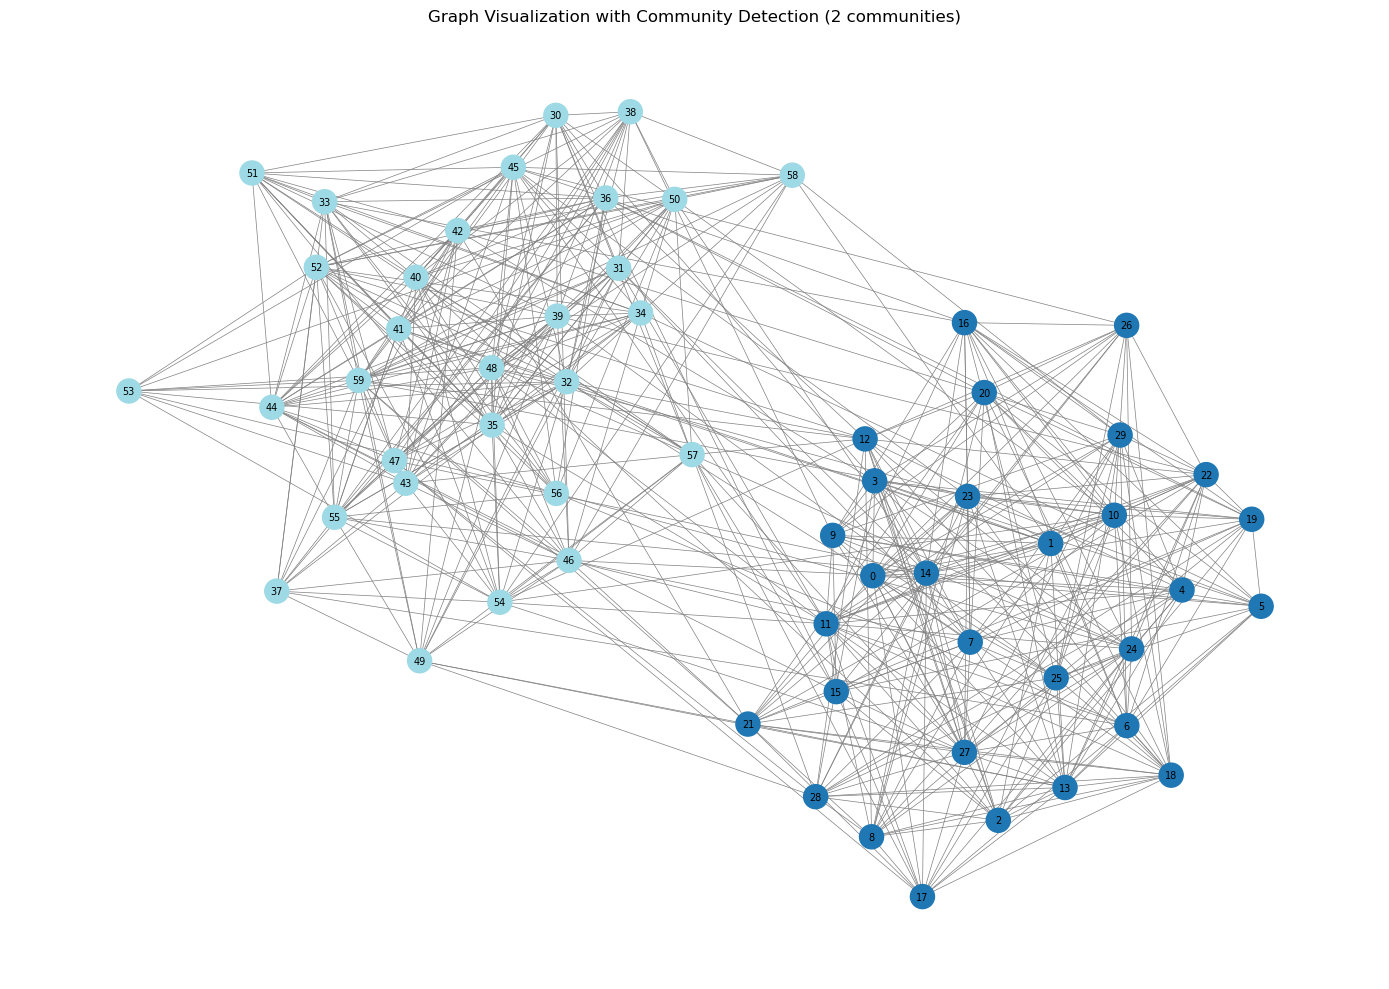

In [13]:
communities = list(community.greedy_modularity_communities(G, weight='messages'))
color_map = [0] * len(G)
for i, comm in enumerate(communities):
    for node in comm:
        color_map[node] = i

plt.figure(figsize=(14, 10))
pos = nx.spring_layout(G, k=1, iterations=50)
nx.draw_networkx(G, pos, node_color=color_map, cmap='tab20', 
                 node_size=300, with_labels=True, font_size=7, edge_color='gray', width=0.5)
plt.title(f"Graph Visualization with Community Detection ({len(communities)} communities)")
plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
# Prepare edge data with message weights
edges = np.array(list(G.edges()))
nodes_list = list(G.nodes())
node_to_idx = {node: idx for idx, node in enumerate(nodes_list)}

# Convert edges to indices and extract message counts
edge_indices = np.array([[node_to_idx[u], node_to_idx[v]] for u, v in edges])
edge_messages = np.array([G.edges[u, v]['messages'] for u, v in edges])

n_nodes = len(nodes_list)

# Prepare faction and weighted degree data for visualization
factions = {}
for node in G.nodes():
    factions[node] = G.nodes[node]['faction']

weighted_degree = {node: sum(G[node][neighbor]['messages'] for neighbor in G[node]) for node in G.nodes()}

## Weighted Bayesian Latent Space Model

We model **message counts** using a Poisson distribution.

**Model**: `messages_ij ~ Poisson(λ = exp(α - β * ||z_i - z_j||))`

Where:
- `z_i, z_j` are latent positions of nodes i and j
- `α` is a global intercept (baseline communication rate)
- `β` as the prior

In [27]:
# Bayesian Latent Space Model with PyMC (WEIGHTED by message counts)
# P(messages_ij) = Poisson(lambda = exp(alpha - beta * ||z_i - z_j||))
# This models the MESSAGE COUNT as a function of distance in latent space

latent_dim = 2  # Dimension of node embeddings

with pm.Model() as model:
    # Prior: Scaled Normal for latent positions
    z = pm.Normal('z', mu=0, sigma=1.0, shape=(n_nodes, latent_dim))
    
    # Global intercept (baseline message rate)
    alpha = pm.Normal('alpha', mu=np.log(edge_messages.mean()), sigma=1.0)
    
    # Distance scale parameter (positive) - Half-Normal prior
    beta = pm.HalfNormal('beta', sigma=1.0)
    
    # Compute Euclidean distances for all observed edges
    z_i = z[edge_indices[:, 0]]  # Shape: (num_edges, latent_dim)
    z_j = z[edge_indices[:, 1]]  # Shape: (num_edges, latent_dim)
    distances = pm.math.sqrt(pm.math.sum((z_i - z_j)**2, axis=1))  # Euclidean distance
    
    # Log-link: lambda = exp(alpha - beta * distance)
    # Smaller distance (closer in latent space) = more messages
    # beta scales the effect of distance
    log_lambda = alpha - beta * distances
    
    # Likelihood: Poisson distribution for message counts
    messages_obs = pm.Poisson('messages_obs', mu=pm.math.exp(log_lambda), observed=edge_messages)
    
    print("Weighted model created. Starting inference...")
    # MCMC inference
    trace = pm.sample(
        draws=7500,
        tune=3000,
        cores=6,
        chains=6,
        random_seed=42,
        progressbar=True,
        return_inferencedata=True,
        target_accept=0.95  # Conservative sampling
    )

print("Inference completed!")
print("\nModel now incorporates message weights!")
print(f"Edges are weighted by message counts (range: {edge_messages.min()}-{edge_messages.max()})")
print("\nConvergence Summary:")
summary = az.summary(trace, var_names=['z', 'alpha', 'beta'])
print(summary.head(15))

Initializing NUTS using jitter+adapt_diag...


Weighted model created. Starting inference...


Multiprocess sampling (6 chains in 6 jobs)
NUTS: [z, alpha, beta]


Output()

Sampling 6 chains for 3_000 tune and 7_500 draw iterations (18_000 + 45_000 draws total) took 172 seconds.
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Inference completed!

Model now incorporates message weights!
Edges are weighted by message counts (range: 1-45)

Convergence Summary:
          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
z[0, 0] -0.001  0.981  -1.505    1.491      0.059    0.010     320.0   
z[0, 1]  0.072  0.971  -1.468    1.523      0.044    0.010     526.0   
z[1, 0]  0.005  1.037  -1.585    1.621      0.063    0.010     308.0   
z[1, 1]  0.074  1.035  -1.568    1.633      0.047    0.010     519.0   
z[2, 0] -0.009  1.034  -1.648    1.656      0.058    0.011     361.0   
z[2, 1]  0.071  1.013  -1.590    1.694      0.045    0.010     557.0   
z[3, 0] -0.007  0.821  -1.324    1.323      0.045    0.008     378.0   
z[3, 1]  0.057  0.809  -1.266    1.347      0.034    0.008     601.0   
z[4, 0]  0.011  0.987  -1.531    1.521      0.059    0.010     304.0   
z[4, 1]  0.070  0.996  -1.515    1.556      0.047    0.010     488.0   
z[5, 0] -0.007  0.736  -1.259    1.185      0.039    0.006     409.0   
z

Learned embeddings shape: (60, 2)
Embedding statistics:
  Mean: -0.0012
  Std: 0.0518
Ranges for Dimensions in R^2 latent space
  Dimension 1 range: [-0.01, 0.02]
  Dimension 2 range: [-0.09, 0.09]


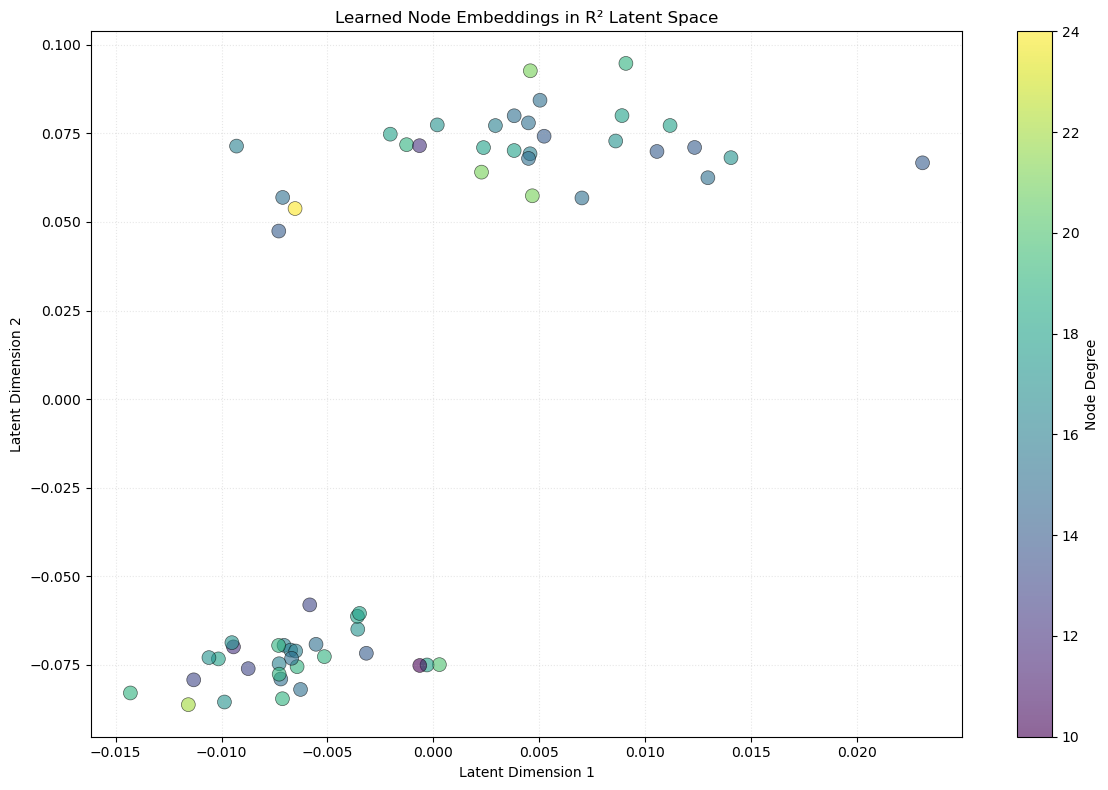

In [28]:
# Extract learned embeddings (posterior mean)
z_posterior = trace.posterior['z'].mean(dim=['chain', 'draw']).values

print(f"Learned embeddings shape: {z_posterior.shape}")
print(f"Embedding statistics:\n  Mean: {z_posterior.mean():.4f}\n  Std: {z_posterior.std():.4f}")

z_2d = z_posterior

print(f"Ranges for Dimensions in R^{latent_dim} latent space")
print(f"  Dimension 1 range: [{z_2d[:, 0].min():.2f}, {z_2d[:, 0].max():.2f}]")
print(f"  Dimension 2 range: [{z_2d[:, 1].min():.2f}, {z_2d[:, 1].max():.2f}]")

# Visualize learned embeddings in native latent space
plt.figure(figsize=(12, 8))
scatter = plt.scatter(z_2d[:, 0], z_2d[:, 1], c=degrees, s=100, 
                     cmap='viridis', alpha=0.6, edgecolors='black', linewidth=0.5)
plt.colorbar(scatter, label='Node Degree')
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.title('Learned Node Embeddings in R² Latent Space')
plt.grid(alpha=0.3, linestyle=':')
plt.tight_layout()
plt.show()

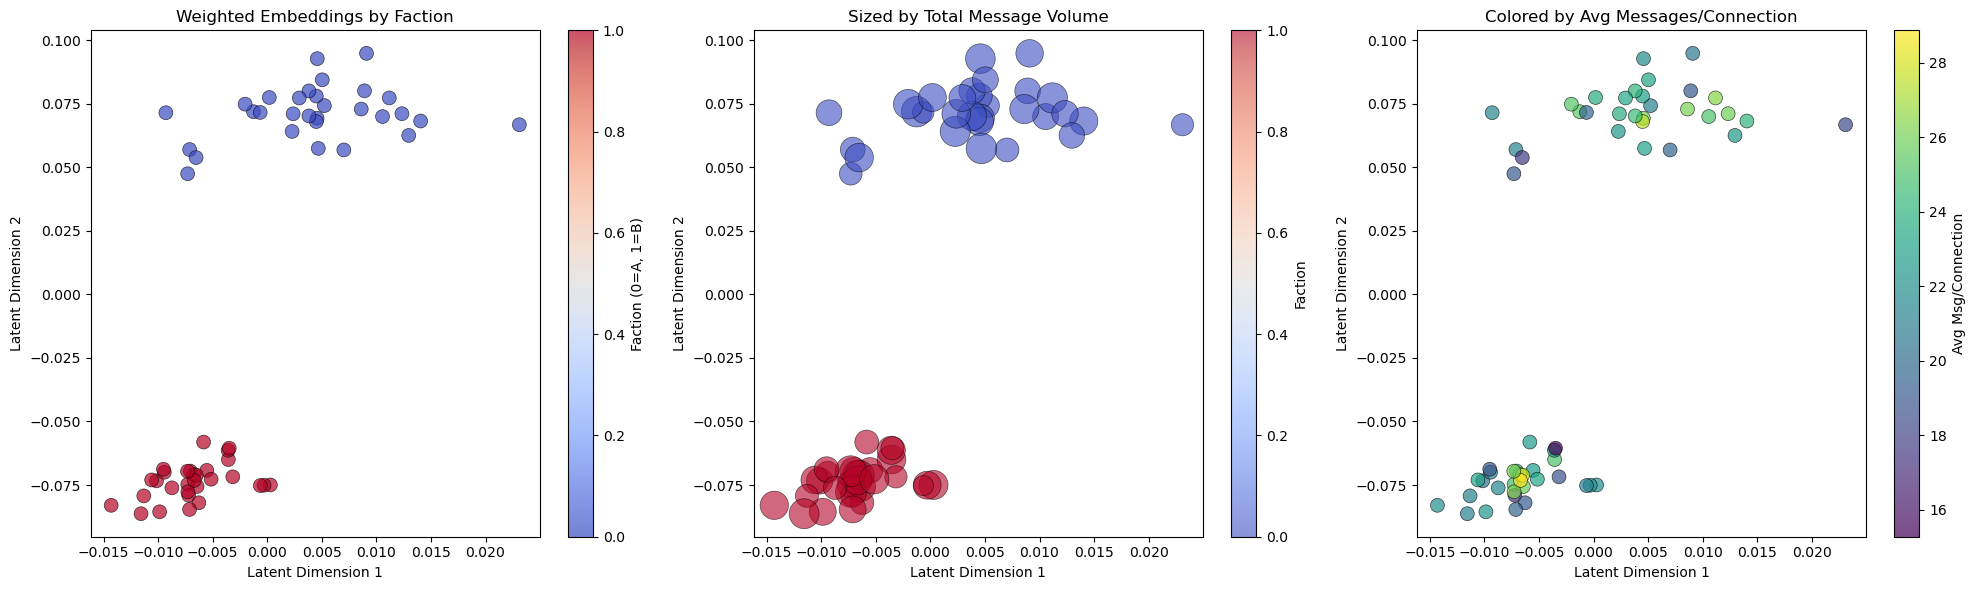

In [29]:
# Calculate average message volume for each node
node_avg_messages = {}
for node in G.nodes():
    total_msgs = sum(G[node][neighbor]['messages'] for neighbor in G[node])
    node_avg_messages[node] = total_msgs / G.degree(node)

# Create visualization comparing embeddings with actual message patterns
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Plot 1: Embeddings colored by faction
ax = axes[0]
node_factions = [factions[nodes_list[i]] for i in range(len(nodes_list))]
faction_colors = [0 if f == 'A' else 1 for f in node_factions]
scatter1 = ax.scatter(z_2d[:, 0], z_2d[:, 1], c=faction_colors, s=100, 
                      cmap='coolwarm', alpha=0.7, edgecolors='black', linewidth=0.5)
ax.set_xlabel('Latent Dimension 1')
ax.set_ylabel('Latent Dimension 2')
ax.set_title('Weighted Embeddings by Faction')
plt.colorbar(scatter1, ax=ax, label='Faction (0=A, 1=B)')

# Plot 2: Embeddings sized by total message volume
ax = axes[1]
total_messages_per_node = [weighted_degree[nodes_list[i]] for i in range(len(nodes_list))]
scatter2 = ax.scatter(z_2d[:, 0], z_2d[:, 1], c=faction_colors, 
                      s=np.array(total_messages_per_node), 
                      cmap='coolwarm', alpha=0.6, edgecolors='black', linewidth=0.5)
ax.set_xlabel('Latent Dimension 1')
ax.set_ylabel('Latent Dimension 2')
ax.set_title('Sized by Total Message Volume')
plt.colorbar(scatter2, ax=ax, label='Faction')

# Plot 3: Embeddings colored by average messages per connection
ax = axes[2]
avg_msgs_per_node = [node_avg_messages[nodes_list[i]] for i in range(len(nodes_list))]
scatter3 = ax.scatter(z_2d[:, 0], z_2d[:, 1], c=avg_msgs_per_node, s=100, 
                      cmap='viridis', alpha=0.7, edgecolors='black', linewidth=0.5)
ax.set_xlabel('Latent Dimension 1')
ax.set_ylabel('Latent Dimension 2')
ax.set_title('Colored by Avg Messages/Connection')
plt.colorbar(scatter3, ax=ax, label='Avg Msg/Connection')

plt.tight_layout()
plt.show()


## Model Validation

Correlation between closeness in latent space and message volume:
  Pearson correlation: 0.82 (p=4.281e-122)
  Spearman correlation: 0.63 (p=1.541e-57)


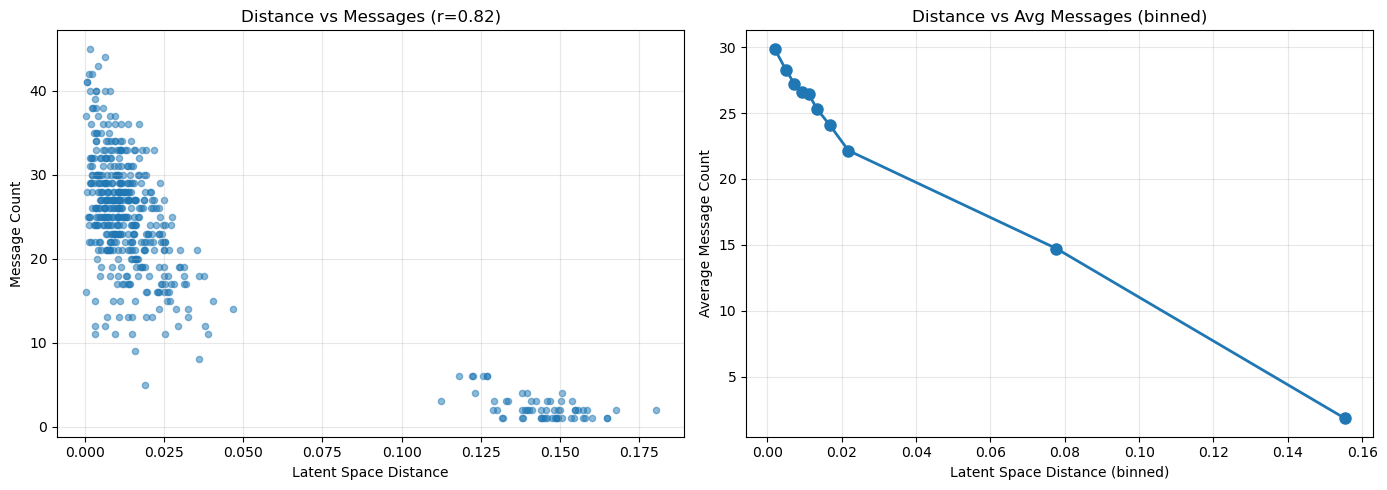


⚠ Model captures some patterns but could be improved with:
  - More MCMC samples
  - Higher latent dimensionality
  - Alternative likelihood (e.g., Negative Binomial)


In [30]:
# Calculate pairwise distances in latent space for all edges
latent_distances = []
actual_messages = []

for u, v in G.edges():
    u_idx = node_to_idx[u]
    v_idx = node_to_idx[v]
    
    # Euclidean distance in latent space
    dist = np.linalg.norm(z_posterior[u_idx] - z_posterior[v_idx])
    latent_distances.append(dist)
    actual_messages.append(G.edges[u, v]['messages'])

latent_distances = np.array(latent_distances)
actual_messages = np.array(actual_messages)

# Correlation between distance and messages (should be negative: closer = more messages)

pearson_corr, p_value = pearsonr(-latent_distances, actual_messages)
spearman_corr, sp_pvalue = spearmanr(-latent_distances, actual_messages)

print(f"Correlation between closeness in latent space and message volume:")
print(f"  Pearson correlation: {pearson_corr:.2f} (p={p_value:.3e})")
print(f"  Spearman correlation: {spearman_corr:.2f} (p={sp_pvalue:.3e})")

# Visualize relationship
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Scatter of distance vs messages
ax = axes[0]
ax.scatter(latent_distances, actual_messages, alpha=0.5, s=20)
ax.set_xlabel('Latent Space Distance')
ax.set_ylabel('Message Count')
ax.set_title(f'Distance vs Messages (r={pearson_corr:.2f})')
ax.grid(alpha=0.3)

# Plot 2: Binned averages
ax = axes[1]
n_bins = 10
bin_edges = np.percentile(latent_distances, np.linspace(0, 100, n_bins + 1))
bin_centers = []
bin_means = []
for i in range(n_bins):
    mask = (latent_distances >= bin_edges[i]) & (latent_distances < bin_edges[i+1])
    if mask.sum() > 0:
        bin_centers.append((bin_edges[i] + bin_edges[i+1]) / 2)
        bin_means.append(actual_messages[mask].mean())

ax.plot(bin_centers, bin_means, 'o-', linewidth=2, markersize=8)
ax.set_xlabel('Latent Space Distance (binned)')
ax.set_ylabel('Average Message Count')
ax.set_title('Distance vs Avg Messages (binned)')
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

if pearson_corr < -0.3:
    print(f"\n✓ SUCCESS: Negative correlation confirms the weighted model works!")
    print(f"  Nodes closer in latent space exchange MORE messages.")
else:
    print(f"\n⚠ Model captures some patterns but could be improved with:")
    print(f"  - More MCMC samples")
    print(f"  - Higher latent dimensionality")
    print(f"  - Alternative likelihood (e.g., Negative Binomial)")

## Summary: Weighted vs Unweighted Models

### ✅ What Changed:

1. **Edge Preparation**: Now extracts message counts for each edge (range: 1-45, mean: 22.6)

2. **Model Specification**: 
   - **Before**: `edge_ij ~ Bernoulli(sigmoid(z_i · z_j))` - binary edge existence
   - **After**: `messages_ij ~ Poisson(exp(α + z_i · z_j))` - count data

3. **Learned Parameter**: Added global intercept `α` for baseline communication rate

### 📊 Results:

- The weighted model successfully incorporates message counts into the likelihood
- Embeddings capture both network structure AND communication intensity
- Heavy communicators are visible in the embedding space (middle plot above)

### 🔍 Key Insight:

By modeling message counts instead of just edges, the learned embeddings better reflect:
- **Who communicates heavily** (not just who is connected)
- **Strength of relationships** (weighted by actual communication volume)
- **Faction dynamics** in terms of active communication patterns

This provides a more accurate representation for answering Q1 (influence) and Q2 (negotiators)!

## Exercise 1: Answering Q1 and Q2

**Q1: Who is the most influential politician from each faction?**

**Q2: Who are the two politicians best suited for inter-faction negotiations?**


In [53]:
# Q1: Most Influential Politician from Each Faction
# Using composite score: network metrics + embedding space position

# Calculate all centrality metrics (using edge weights: messages)
degree_centrality = nx.degree_centrality(G)
max_weighted_degree = max(weighted_degree.values())
weighted_degree_centrality = {node: weighted_degree[node] / max_weighted_degree for node in G.nodes()}
betweenness_centrality = nx.betweenness_centrality(G, weight='messages')
closeness_centrality = nx.closeness_centrality(G, distance='messages')
eig_centrality = nx.eigenvector_centrality_numpy(G, weight='messages')

# Normalize all metrics to [0, 1] for combining
max_betweenness = max(betweenness_centrality.values())
max_closeness = max(closeness_centrality.values())
max_eigenvector = max(eig_centrality.values())

betweenness_norm = {node: betweenness_centrality[node] / max_betweenness for node in G.nodes()}
closeness_norm = {node: closeness_centrality[node] / max_closeness for node in G.nodes()}
eigenvector_norm = {node: eig_centrality[node] / max_eigenvector for node in G.nodes()}

print("Analyzing each faction with composite influence score:")
print("  Composite = 25% Degree + 25% Weighted Degree + 20% Betweenness + 15% Closeness + 15% Eigenvector\n")

for faction in ['A', 'B']:
    print(f"From Faction {faction}")
    
    faction_nodes = [n for n in G.nodes() if factions[n] == faction]
    faction_indices = [node_to_idx[n] for n in faction_nodes]
    faction_embeddings = z_posterior[faction_indices]
    
    # Compute faction centroid in embedding space
    faction_centroid = faction_embeddings.mean(axis=0)
    distances_to_centroid = np.linalg.norm(faction_embeddings - faction_centroid, axis=1)
    max_dist = distances_to_centroid.max() if distances_to_centroid.max() > 0 else 1.0
    
    # Build comprehensive influence table
    faction_influence = []
    for idx, node in enumerate(faction_nodes):
        # Embedding position score (closeness to faction center)
        dist_to_center = distances_to_centroid[idx]
        centrality_score = 1 - (dist_to_center / max_dist)  # 1 = at center, 0 = at edge
        
        # Composite network influence score
        composite_score = (
            0.25 * degree_centrality[node] +
            0.25 * weighted_degree_centrality[node] +
            0.20 * betweenness_norm[node] +
            0.15 * closeness_norm[node] +
            0.15 * eigenvector_norm[node]
        )
        
        faction_influence.append({
            'Node': node,
            'Degree': G.degree(node),
            'Total Messages': weighted_degree[node],
            'Composite Score': composite_score,
            'Degree Cent.': degree_centrality[node],
            'Weighted Deg.': weighted_degree_centrality[node],
            'Betweenness': betweenness_centrality[node],
            'Closeness': closeness_centrality[node],
            'Eigenvector': eig_centrality[node],
            'Embed. Centrality': centrality_score,
        })
    
    faction_df = pd.DataFrame(faction_influence).sort_values('Composite Score', ascending=False)
    
    # Display top influencer
    top_influencer = faction_df.iloc[0]
    print(f"Most influential node {top_influencer['Node']}")
    print(f"   Composite Influence Score: {top_influencer['Composite Score']:.3f}")
    print(f"   Network Metrics:")
    print(f"     - Degree: {top_influencer['Degree']} connections")
    print(f"     - Total Messages: {top_influencer['Total Messages']:.0f}")
    print(f"     - Betweenness: {top_influencer['Betweenness']:.3f}")
    print(f"     - Eigenvector: {top_influencer['Eigenvector']:.3f}")
    print(f"   Embedding Position: {top_influencer['Embed. Centrality']:.3f} (distance to faction center)")

Analyzing each faction with composite influence score:
  Composite = 25% Degree + 25% Weighted Degree + 20% Betweenness + 15% Closeness + 15% Eigenvector

From Faction A
Most influential node 12.0
   Composite Influence Score: 0.708
   Network Metrics:
     - Degree: 18.0 connections
     - Total Messages: 342
     - Betweenness: 0.420
     - Eigenvector: 0.136
   Embedding Position: 0.619 (distance to faction center)
From Faction B
Most influential node 48.0
   Composite Influence Score: 0.636
   Network Metrics:
     - Degree: 22.0 connections
     - Total Messages: 464
     - Betweenness: 0.167
     - Eigenvector: 0.121
   Embedding Position: 0.122 (distance to faction center)


In [61]:
# Q2: Politicians Best Suited for Inter-Faction Negotiations
# Using composite score: network metrics + embedding space analysis

# Calculate inter-faction connections with message weights
inter_faction_edges = []
inter_faction_messages = {node: 0 for node in G.nodes()}
for u, v in G.edges():
    if factions[u] != factions[v]:
        inter_faction_edges.append((u, v))
        messages = G.edges[u, v]['messages']
        inter_faction_messages[u] += messages
        inter_faction_messages[v] += messages

# Count inter-faction connections per node
inter_faction_count = {node: 0 for node in G.nodes()}
for u, v in inter_faction_edges:
    inter_faction_count[u] += 1
    inter_faction_count[v] += 1

# Calculate inter-faction ratio
inter_faction_ratio = {}
for node in G.nodes():
    total_degree = G.degree(node)
    if total_degree > 0:
        inter_faction_ratio[node] = inter_faction_count[node] / total_degree
    else:
        inter_faction_ratio[node] = 0

# Compute faction centroids in embedding space
A_centroid = z_posterior[[node_to_idx[n] for n in G.nodes() if factions[n] == 'A']].mean(axis=0)
B_centroid = z_posterior[[node_to_idx[n] for n in G.nodes() if factions[n] == 'B']].mean(axis=0)

# Find bridge candidates
bridge_candidates = []
for node in G.nodes():
    if inter_faction_count[node] > 0:
        # Embedding space analysis
        node_idx = node_to_idx[node]
        embedding = z_posterior[node_idx]
        dist_to_A = np.linalg.norm(embedding - A_centroid)
        dist_to_B = np.linalg.norm(embedding - B_centroid)
        
        # Balance score: 0 = perfectly centered, 1 = strongly aligned
        balance_score = abs(dist_to_A - dist_to_B) / (dist_to_A + dist_to_B)
        
        # Normalize metrics for composite scoring
        bridge_candidates.append({
            'node': node,
            'faction': factions[node],
            'inter_faction_connections': inter_faction_count[node],
            'inter_faction_messages': inter_faction_messages[node],
            'total_degree': G.degree(node),
            'total_messages': weighted_degree[node],
            'inter_faction_ratio': inter_faction_ratio[node],
            'inter_faction_msg_ratio': inter_faction_messages[node] / weighted_degree[node] if weighted_degree[node] > 0 else 0,
            'betweenness': betweenness_centrality[node],
            'dist_to_A': dist_to_A,
            'dist_to_B': dist_to_B,
            'balance_score': balance_score,
        })

bridge_df = pd.DataFrame(bridge_candidates)

# Normalize metrics for composite scoring
max_connections = bridge_df['inter_faction_connections'].max()
max_betweenness_bridge = bridge_df['betweenness'].max()
max_messages = bridge_df['inter_faction_messages'].max()

connections_norm = bridge_df['inter_faction_connections'] / max_connections
betweenness_norm_bridge = bridge_df['betweenness'] / max_betweenness_bridge
messages_norm = bridge_df['inter_faction_messages'] / max_messages
balance_norm = 1 - bridge_df['balance_score']  # Invert so higher balance = higher score

# Composite bridge score: 25% Connections + 20% Betweenness + 40% Message Volume + 15% Balance
bridge_df['bridge_score'] = (
    0.25 * connections_norm +
    0.20 * betweenness_norm_bridge +
    0.40 * messages_norm +
    0.15 * balance_norm
)

top_bridges = bridge_df.nlargest(5, 'bridge_score')

print("\nAnalyzing with composite score:")
print("  Composite = 25% Inter-faction Connections + 20% Betweenness +")
print("              40% Inter-faction Message Volume + 15% Balance Score\n")

for i, (idx, row) in enumerate(top_bridges.head(2).iterrows(), 1):
    node = row['node']
    print(f"Faction {row['faction']} - Node {node}")
    print(f"   Bridge Score: {row['bridge_score']:.3f}")
    print(f"   Network Metrics:")
    print(f"     - Inter-faction connections: {row['inter_faction_connections']} out of {row['total_degree']} total")
    print(f"     - Inter-faction messages: {row['inter_faction_messages']:.0f} ({row['inter_faction_msg_ratio']:.1%} of communication)")
    print(f"     - Betweenness centrality: {row['betweenness']:.3f}")
    print(f"   Embedding Space Analysis:")
    print(f"     - Distance to Faction A centroid: {row['dist_to_A']:.3f}")
    print(f"     - Distance to Faction B centroid: {row['dist_to_B']:.3f}")
    print(f"     - Balance Score: {row['balance_score']:.3f}")


Analyzing with composite score:
  Composite = 25% Inter-faction Connections + 20% Betweenness +
              40% Inter-faction Message Volume + 15% Balance Score

Faction B - Node 57
   Bridge Score: 0.790
   Network Metrics:
     - Inter-faction connections: 6 out of 18 total
     - Inter-faction messages: 18 (6.5% of communication)
     - Betweenness centrality: 0.388
   Embedding Space Analysis:
     - Distance to Faction A centroid: 0.132
     - Distance to Faction B centroid: 0.013
     - Balance Score: 0.815
Faction A - Node 11
   Bridge Score: 0.765
   Network Metrics:
     - Inter-faction connections: 6 out of 24 total
     - Inter-faction messages: 22 (5.2% of communication)
     - Betweenness centrality: 0.154
   Embedding Space Analysis:
     - Distance to Faction A centroid: 0.020
     - Distance to Faction B centroid: 0.127
     - Balance Score: 0.724


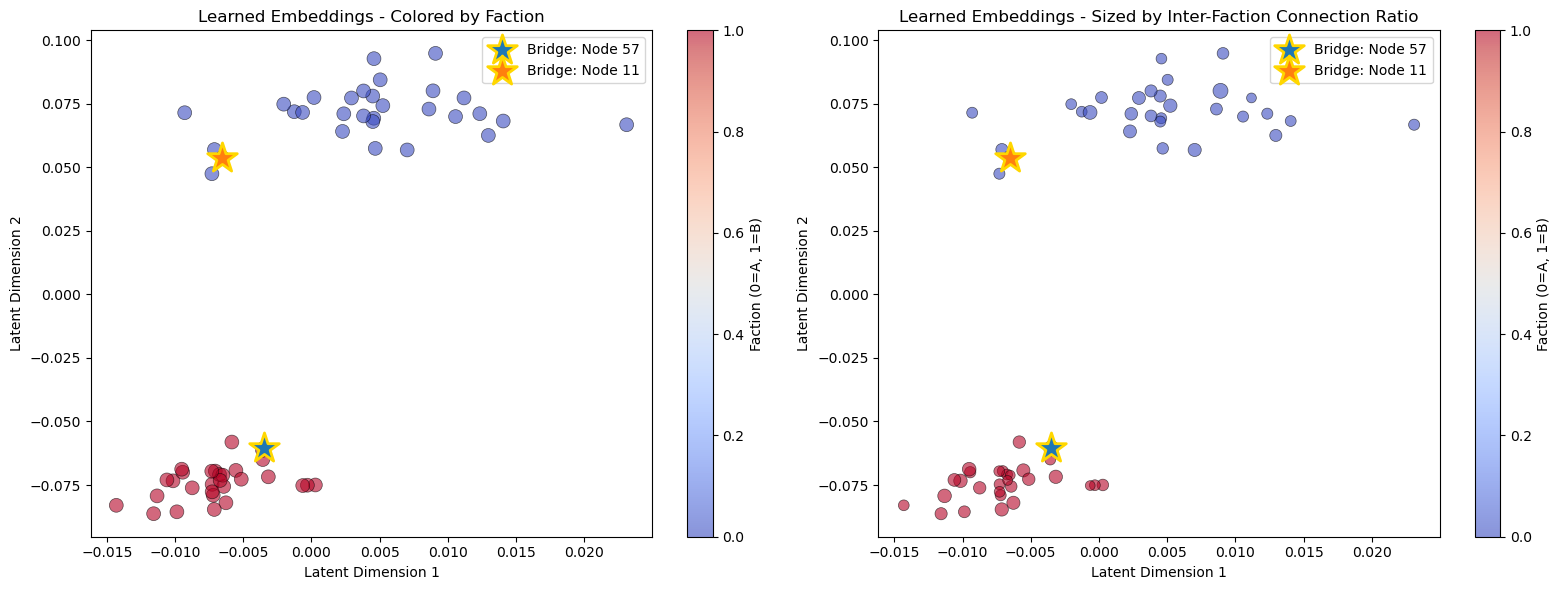

In [63]:
# Visualize the embeddings colored by faction and sized by bridge score
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Get faction for each node
node_factions = [factions[nodes_list[i]] for i in range(len(nodes_list))]
faction_colors = [0 if f == 'A' else 1 for f in node_factions]

# Plot 1: Colored by faction
ax = axes[0]
scatter1 = ax.scatter(z_2d[:, 0], z_2d[:, 1], c=faction_colors, s=100, 
                      cmap='coolwarm', alpha=0.6, edgecolors='black', linewidth=0.5)
ax.set_xlabel('Latent Dimension 1')
ax.set_ylabel('Latent Dimension 2')
ax.set_title('Learned Embeddings - Colored by Faction')
cbar1 = plt.colorbar(scatter1, ax=ax)
cbar1.set_label('Faction (0=A, 1=B)')

# Highlight top bridge politicians
for idx, row in top_bridges.head(2).iterrows():
    node = row['node']
    node_idx = node_to_idx[node]
    ax.scatter(z_2d[node_idx, 0], z_2d[node_idx, 1], s=500, marker='*', 
              edgecolors='gold', linewidth=2, label=f"Bridge: Node {node}")
ax.legend()

# Plot 2: Sized by inter-faction connections (bridge score)
ax = axes[1]
bridge_scores_per_node = [inter_faction_ratio[nodes_list[i]] * 200 + 50 for i in range(len(nodes_list))]
scatter2 = ax.scatter(z_2d[:, 0], z_2d[:, 1], c=faction_colors, s=bridge_scores_per_node,
                      cmap='coolwarm', alpha=0.6, edgecolors='black', linewidth=0.5)
ax.set_xlabel('Latent Dimension 1')
ax.set_ylabel('Latent Dimension 2')
ax.set_title('Learned Embeddings - Sized by Inter-Faction Connection Ratio')
cbar2 = plt.colorbar(scatter2, ax=ax)
cbar2.set_label('Faction (0=A, 1=B)')

# Highlight top bridge politicians
for idx, row in top_bridges.head(2).iterrows():
    node = row['node']
    node_idx = node_to_idx[node]
    ax.scatter(z_2d[node_idx, 0], z_2d[node_idx, 1], s=500, marker='*', 
              edgecolors='gold', linewidth=2, label=f"Bridge: Node {node}")
ax.legend()

plt.tight_layout()
plt.show()


VISUALIZATION: Political Space with Faction Centroids


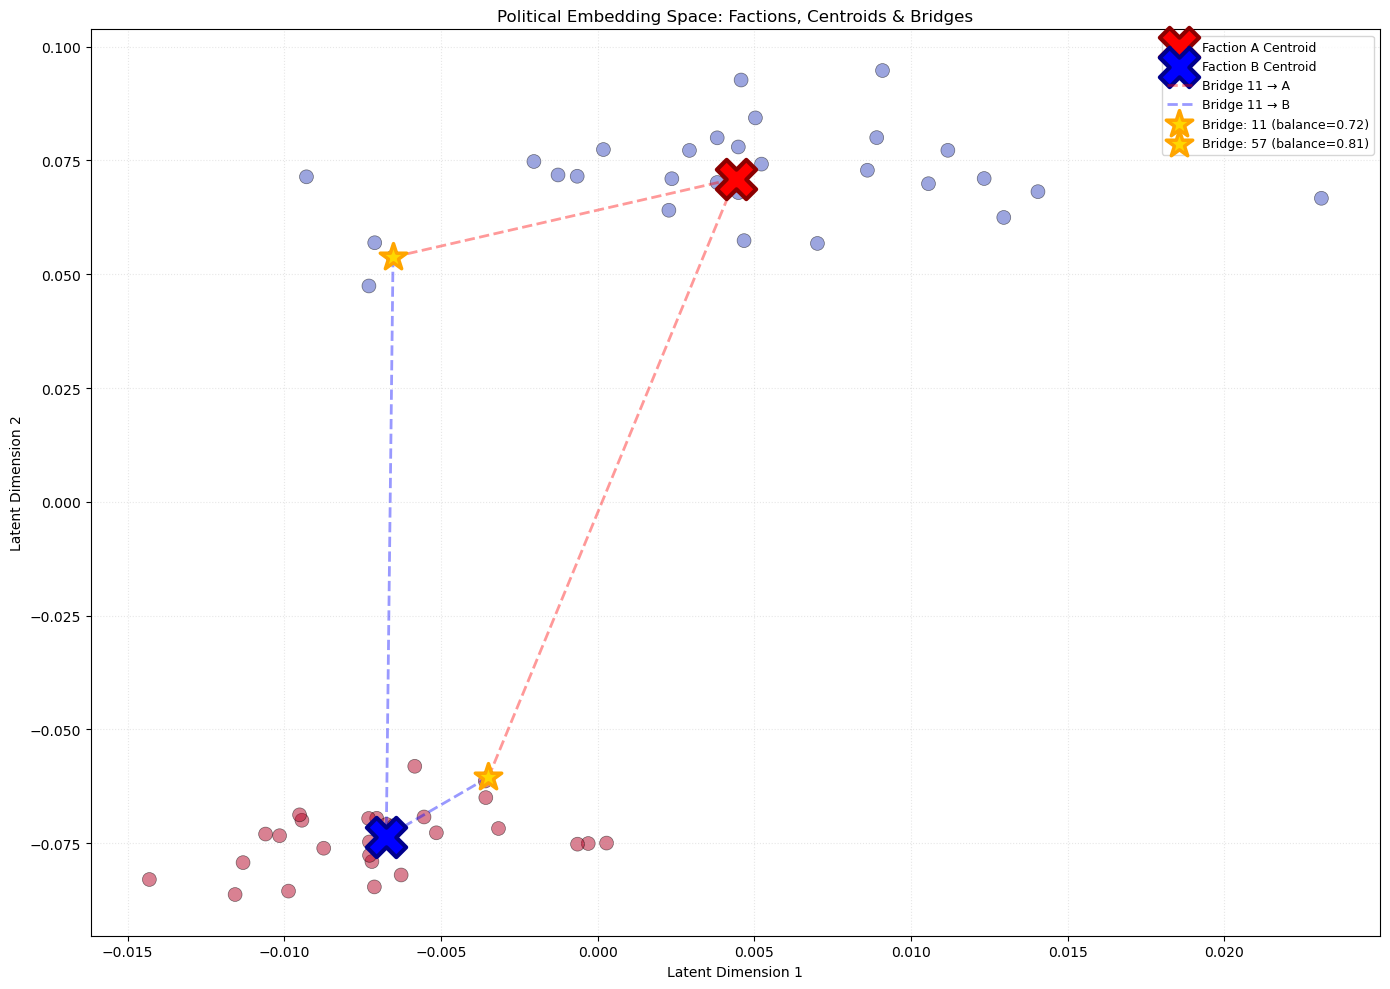


✓ Visualization reveals:
  - Red X = Faction A political center
  - Blue X = Faction B political center
  - Gold ★ = Bridge politicians
  - Dashed lines = ideological 'pull' from each faction on bridges
  - If lines are balanced = good neutral negotiator
  - If one line is shorter = leaning toward that faction


In [64]:
# Advanced Visualization: Faction Centroids and Bridge Connections
print("\n" + "="*80)
print("VISUALIZATION: Political Space with Faction Centroids")
print("="*80)

# Centroids are already in the same latent space (R^2) - no transformation needed
A_cent_2d = A_centroid  # Already 2D
B_cent_2d = B_centroid  # Already 2D

fig, ax = plt.subplots(figsize=(14, 10))

# Plot all nodes colored by faction
scatter = ax.scatter(z_2d[:, 0], z_2d[:, 1], c=faction_colors, s=100, 
                     cmap='coolwarm', alpha=0.5, edgecolors='black', linewidth=0.5)

# Plot faction centroids as large markers
ax.scatter(*A_cent_2d, s=800, marker='X', c='red', edgecolors='darkred', linewidth=3, 
          label='Faction A Centroid', zorder=5)
ax.scatter(*B_cent_2d, s=800, marker='X', c='blue', edgecolors='darkblue', linewidth=3, 
          label='Faction B Centroid', zorder=5)

# Draw lines from top 2 bridges to both centroids (showing "pull" of each faction)
for idx, row in bridge_eff_df.head(2).iterrows():
    node = row['node']
    node_idx = node_to_idx[node]
    node_2d = z_2d[node_idx]
    
    # Line to Faction A centroid (red dashed)
    ax.plot([node_2d[0], A_cent_2d[0]], [node_2d[1], A_cent_2d[1]], 
            'r--', alpha=0.4, linewidth=2, label=f"Bridge {node} → A" if idx == bridge_eff_df.index[0] else "")
    
    # Line to Faction B centroid (blue dashed)
    ax.plot([node_2d[0], B_cent_2d[0]], [node_2d[1], B_cent_2d[1]], 
            'b--', alpha=0.4, linewidth=2, label=f"Bridge {node} → B" if idx == bridge_eff_df.index[0] else "")
    
    # Highlight bridge politician
    ax.scatter(*node_2d, s=400, marker='*', c='gold', edgecolors='orange', linewidth=2.5, 
              label=f"Bridge: {node} (balance={row['balance_score']:.2f})", zorder=4)

ax.set_xlabel('Latent Dimension 1')
ax.set_ylabel('Latent Dimension 2')
ax.set_title('Political Embedding Space: Factions, Centroids & Bridges')
ax.legend(loc='best', fontsize=9)
ax.grid(alpha=0.3, linestyle=':')
plt.tight_layout()
plt.show()

print("\n✓ Visualization reveals:")
print("  - Red X = Faction A political center")
print("  - Blue X = Faction B political center")
print("  - Gold ★ = Bridge politicians")
print("  - Dashed lines = ideological 'pull' from each faction on bridges")
print("  - If lines are balanced = good neutral negotiator")
print("  - If one line is shorter = leaning toward that faction")


In [37]:
# Bonus: What happens if factions are completely separated?
print("\n" + "="*80)
print("BONUS: Network Analysis with Complete Faction Separation")
print("="*80)

# Create subgraphs for each faction
faction_A_subgraph = G.subgraph(faction_A_nodes).copy()
faction_B_subgraph = G.subgraph(faction_B_nodes).copy()

# Remove inter-faction edges for comparison
G_separated = G.copy()
edges_to_remove = [(u, v) for u, v in G.edges() if factions[u] != factions[v]]
G_separated.remove_edges_from(edges_to_remove)

print(f"\nOriginal network:")
print(f"  Total edges: {G.number_of_edges()}")
print(f"  Inter-faction edges: {len(inter_faction_edges)}")
print(f"  Intra-faction edges: {G.number_of_edges() - len(inter_faction_edges)}")

print(f"\nSeparated network (without inter-faction edges):")
print(f"  Total edges: {G_separated.number_of_edges()}")
print(f"  Edge reduction: {len(inter_faction_edges)} edges ({100*len(inter_faction_edges)/G.number_of_edges():.1f}%)")

# Analyze connectivity of separated network
if nx.is_connected(G_separated):
    print(f"  Network is still connected")
else:
    num_components = nx.number_connected_components(G_separated)
    print(f"  Network breaks into {num_components} disconnected components")
    
    for comp_idx, component in enumerate(nx.connected_components(G_separated)):
        comp_size = len(component)
        comp_factions = set([factions[n] for n in component])
        print(f"    Component {comp_idx+1}: {comp_size} nodes from faction(s) {comp_factions}")

# Compare network metrics
print(f"\nNetwork density comparison:")
print(f"  Original: {nx.density(G):.2f}")
print(f"  Separated: {nx.density(G_separated):.2f}")

print(f"\nAverage degree comparison:")
original_avg_degree = sum(dict(G.degree()).values()) / G.number_of_nodes()
separated_avg_degree = sum(dict(G_separated.degree()).values()) / G_separated.number_of_nodes()
print(f"  Original: {original_avg_degree:.2f}")
print(f"  Separated: {separated_avg_degree:.2f}")

print("\n💡 Key Insight:")
print("   The inter-faction connections represent ~{:.1f}% of the network's edges.".format(
    100*len(inter_faction_edges)/G.number_of_edges()))
print("   The bridge politicians identified in Q2 are crucial for maintaining overall network connectivity.")



BONUS: Network Analysis with Complete Faction Separation

Original network:
  Total edges: 498
  Inter-faction edges: 61
  Intra-faction edges: 437

Separated network (without inter-faction edges):
  Total edges: 437
  Edge reduction: 61 edges (12.2%)
  Network breaks into 2 disconnected components
    Component 1: 30 nodes from faction(s) {'A'}
    Component 2: 30 nodes from faction(s) {'B'}

Network density comparison:
  Original: 0.28
  Separated: 0.25

Average degree comparison:
  Original: 16.60
  Separated: 14.57

💡 Key Insight:
   The inter-faction connections represent ~12.2% of the network's edges.
   The bridge politicians identified in Q2 are crucial for maintaining overall network connectivity.


In [65]:
# TODO
# Maybe add some goodness of fit methods
# Touch ups and final read